In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy as sp
import time



In [2]:
def proposal_sample():
    # propose m1, m2, m3
    m1 = np.random.uniform(-30, 30)
    m2 = np.random.uniform(-10, 10)
    m3 = np.random.uniform(-0.1, 0.1)
    return np.array([m1,m2,m3])

def forward(m,x_obs):
    d = m[0] + m[1] * x_obs + m[2] * x_obs**2
    return d

def f2_pdf(d, d_obs, d_std):
    useLog = True
    f = -0.5 * np.sum((d_obs - d) ** 2 / (d_std ** 2))
    #f = exp(f)
    return f

def f1_pdf(m):
    fm1 = norm.pdf(m[0], 0, 10)

    if (m[1] > 10) or (m[1] < -10):
        fm2 = 0
    else:
        fm2 = 1 / 20

    if (m[2] > 0.1) or (m[2] < -0.1):
        fm3 = 0
    else:
        fm3 = 1 / 0.2

    f = fm1 * fm2 * fm3
    f = np.log(fm1)+np.log(fm2)+np.log(fm3)
    return f

def plot_sample_histogram(m_sample, nbins=100):
    plt.figure()

    plt.subplot(3, 1, 1)
    plt.hist(m_sample[:,0], bins=nbins, range=(-35, 35))
    plt.title('m1')

    plt.subplot(3, 1, 2)
    plt.hist(m_sample[:,1], bins=nbins, range=(-12, 12))
    plt.title('m2')

    plt.subplot(3, 1, 3)
    plt.hist(m_sample[:,2], bins=nbins, range=(-0.12, .12))
    plt.title('m3')

    plt.suptitle('1D marginal')

    

def plot_autocorrelation(m_post, maxlags=100, dlag=10):
    nm=m_post.shape[1]
    
    fig, ax = plt.subplots(nm, 1)
    for ix in range(nm):
        #plt.subplot(nm, 1, ix+1)
        ax[ix].acorr(m_post[::dlag, ix]-np.mean(m_post[:,ix]) , usevlines=False, maxlags=maxlags, normed=True, lw=2)
        ax[ix].set_title('m%d'%(ix+1))
        ax[ix].set_ylabel('Normalized \n Autocorrelation')
        ax[ix].grid()
        ax[ix].set_ylim([-.2, 1])
    plt.tight_layout()
    plt.xlabel('Lag (lag-distance=%d)' % dlag)

def plot_sample(m_sample, ax=None):

    nm=m_sample.shape[1]

    # construct ax and fig handle for three subplots
    # if ax is None do next line

    if ax is None:
        fig, ax = plt.subplots(nm, 1)

    for ix in range(nm):
        ax[ix].plot(m_sample[:,ix])
        ax[ix].grid()
        ax[ix].set_ylabel('m%d' % (ix+1) )
    ax[ix].set_xlabel('Iteration/realization number')
    plt.tight_layout()


    return ax

def plot_data(x_obs, d_obs, d_std):
    plt.errorbar(x_obs, d_obs, yerr=2*d_std, fmt='k.', linewidth=2,  label='Observations')
    plt.xlabel('x')
    plt.ylabel('d')
    plt.grid(True)
    plt.xlim([0, 50])



def plot_lines(m_sample, nshow=500):
    n = len(m_sample)
    nshow = min(n, nshow)

    for i in range(0, n, int(n / nshow)):
        d_test = forward(m_sample[i, :], x_test)
        plt.plot(x_test, d_test, 'r-', linewidth=.1)

## Load and plot the data

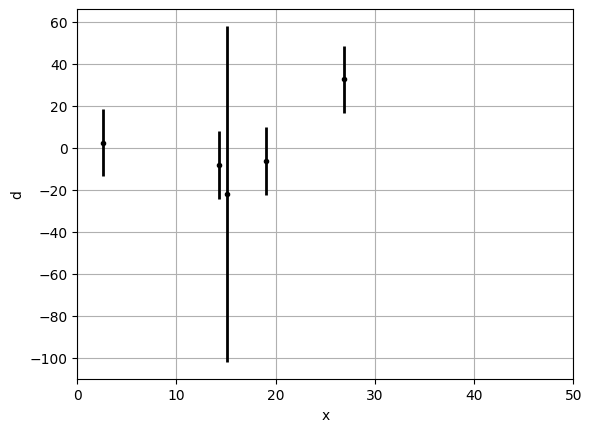

In [3]:
M=sp.io.loadmat('linefit_nd05.mat') # loads the data set with 5 observations
#M=sp.io.loadmat('linefit_nd35.mat') # loads the data set with 35 observations

d_obs = np.float32(M['d_obs'].flatten()) # Extract the 1D array from the loaded data
d_std = np.float32(M['d_std'].flatten())
x_obs = np.float32(M['x_obs'].flatten())
x_test = np.arange(0, 50, .1)
nx=len(x_test)
# show the data

plot_data(x_obs, d_obs, d_std)
plt.show()



## Exercise A
Use the normal cumulative probability density, to directly propose independent realization of $f_1(\mathbf{m})$.


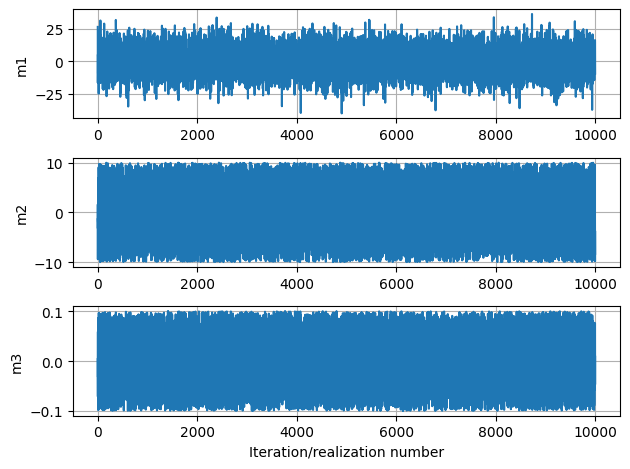

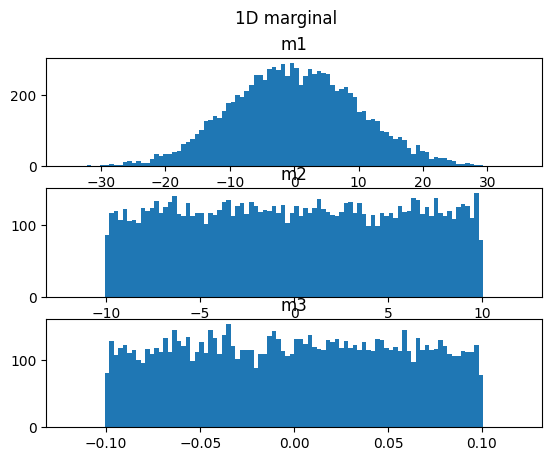

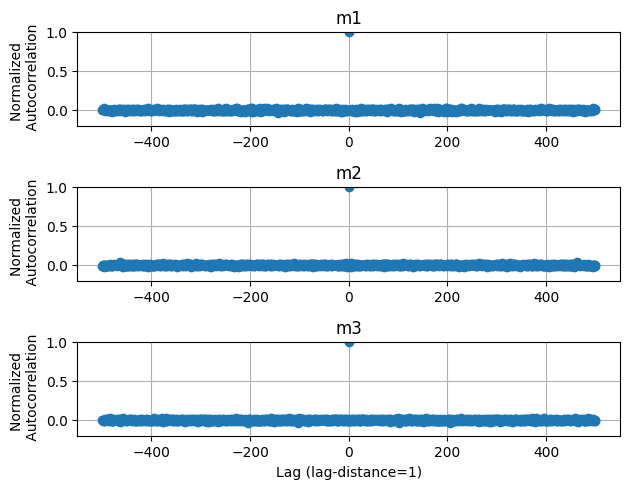

In [4]:
# generate a sample form a uniform distribution, between 0 and 1


def f1_sample():
    m1 = np.random.normal(0, 10)
    m2 = np.random.uniform(-10,10)
    m3 = np.random.uniform(-.1,.1)
    return np.array([m1,m2,m3])


N=10000
m_sample = np.zeros((N, 3))
for i in range(N):
    m_real = f1_sample()
    m_sample[i, :] = m_real


plot_sample(m_sample)
plt.show()

plot_sample_histogram(m_sample)
plt.show()

plot_autocorrelation(m_sample, maxlags=500, dlag=1)
plt.show()



## Exercise B
Use the classical Metropolis sampler to sample $f_1(\mathbf{m})$.

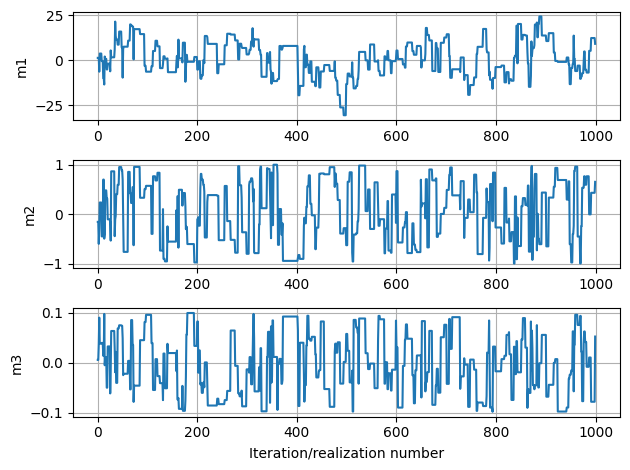

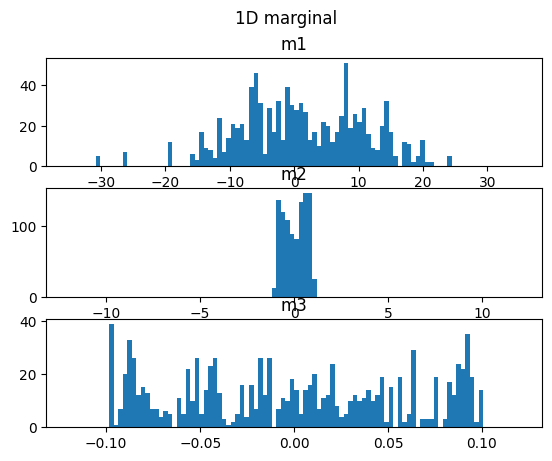

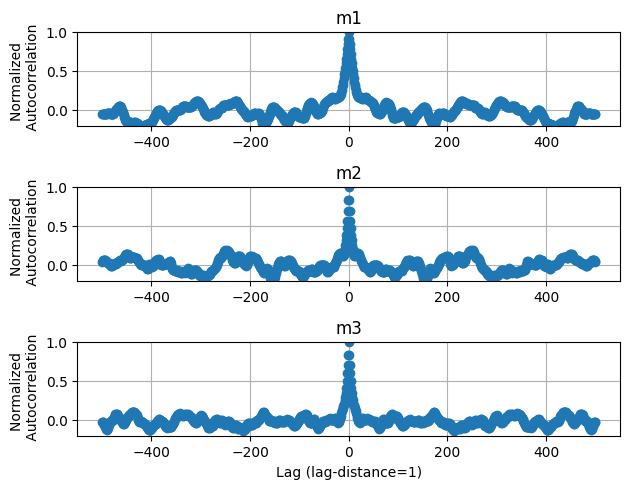

In [5]:
def sample_prior_metropolis(m_current=np.array([0,0,0]), 
                            step=np.array([1, .1 ,.01])):
    
    
    m_propose = m_current.copy() + step * np.random.randn(3)


    f1_cur =  sp.stats.norm.pdf(m_current[0], 0, 10)
    f2_cur=1
    if np.abs(m_current[1])>1:
        f2_cur = 0
    f3_cur=1    
    if np.abs(m_current[2])>.1:
        f3_cur = 0
    f_current = f1_cur*f2_cur*f3_cur

    f1_pro =  sp.stats.norm.pdf(m_propose[0], 0, 10)
    f2_pro=1
    if np.abs(m_propose[1])>1:
        f2_pro = 0
    f3_pro=1
    if np.abs(m_propose[2])>.1:
        f3_pro = 0
    f_propose = f1_pro*f2_pro*f3_pro    

    P_acc = f_propose/f_current
    if np.random.uniform(0, 1) < P_acc:
        m_current = m_propose
            
    return m_current


N=1000
m_sample = np.zeros((N, 3))
step = 1*np.array([10,1,.1])
m_propose = sample_prior_metropolis()
for i in range(N):
    m_propose = sample_prior_metropolis(m_propose,step)
    m_sample[i, :] = m_propose


plot_sample(m_sample)
plt.show()

plot_sample_histogram(m_sample)
plt.show()

plot_autocorrelation(m_sample, maxlags=500, dlag=1)
plt.show()



## Exercise C
Use the inverse normal cumulative probability density, to sample from $f_1(\mathbf{m})$..


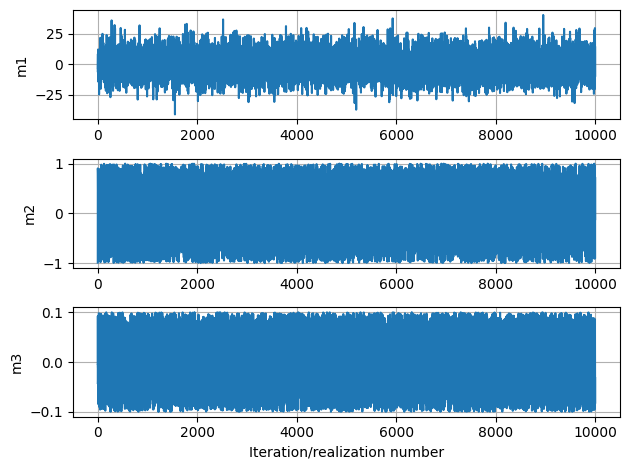

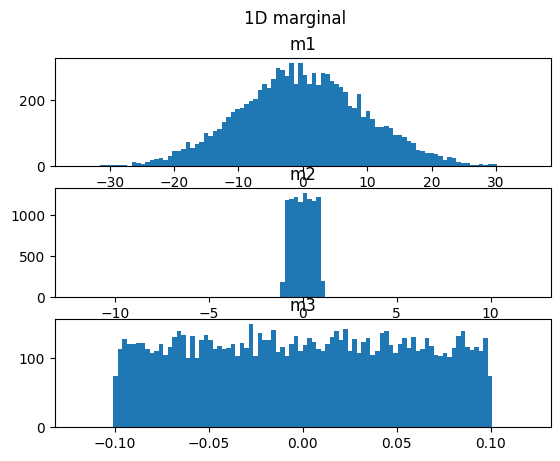

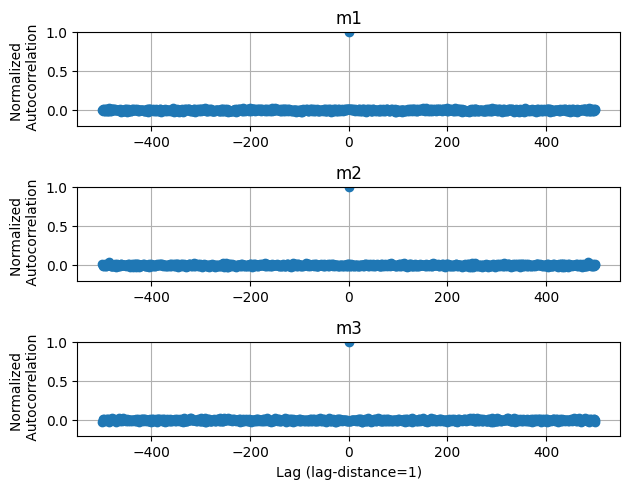

In [6]:
def sample_prior_inversion():
    r1 = np.random.uniform(0, 1)
    m1_propose = sp.stats.norm.ppf(r1, 0, 10)
    # U(-1,1)
    r2 = np.random.uniform(0, 1)
    m2_propose = 2*sp.stats.uniform.ppf(r2)-1
    # U(-.1,.1)
    r3 = np.random.uniform(0, 1)
    m3_propose = .2*sp.stats.uniform.ppf(r3)-.1

    m_propose = np.array([m1_propose, m2_propose, m3_propose])

    return m_propose


N=10000
m_sample = np.zeros((N, 3))
for i in range(N):
    m_real = sample_prior_inversion()
    m_sample[i, :] = m_real


plot_sample(m_sample)
plt.show()

plot_sample_histogram(m_sample)
plt.show()

plot_autocorrelation(m_sample, maxlags=500, dlag=1)
plt.show()




## Exercise D
Sample $f_1(\mathbf{m}_1)$ iusing gradual deformation

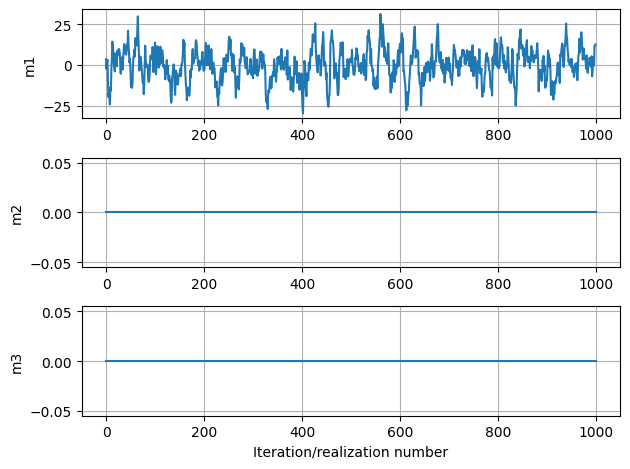

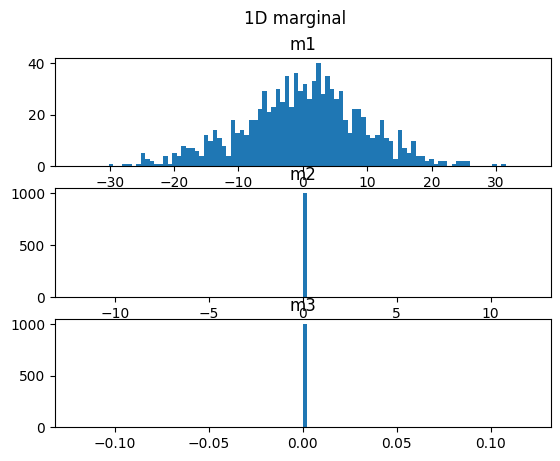

/home/au11687/miniconda3/envs/tf/lib/python3.9/site-packages/matplotlib/axes/_axes.py:2083: RuntimeWarning: divide by zero encountered in divide
  correls /= np.sqrt(np.dot(x, x) * np.dot(y, y))
/home/au11687/miniconda3/envs/tf/lib/python3.9/site-packages/matplotlib/axes/_axes.py:2083: RuntimeWarning: invalid value encountered in divide
  correls /= np.sqrt(np.dot(x, x) * np.dot(y, y))


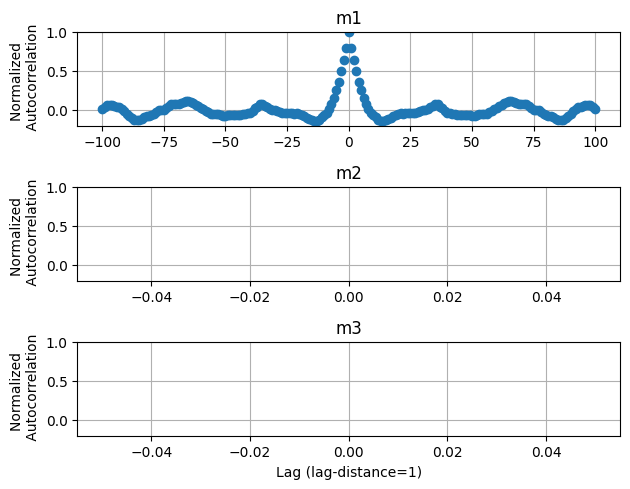

In [7]:
def sample_prior_gdm(m_c=0, step=0.1, m0=0, std=10, ):

    m_p = np.random.normal(m0, std)
    if (m_c==0):
        m_propose = m_p
    else:
        m_propose = m0 + np.cos(step*np.pi/2)*(m_c-m0) + np.sin(step*np.pi/2)*(m_p-m0)
    return m_propose

m_real = sample_prior_gdm()
    
N=1000
step= .4
m_sample = np.zeros((N, 3))
for i in range(N):
    m_real = sample_prior_gdm(m_real,step)
    m_sample[i, 0] = m_real


plot_sample(m_sample)
plt.show()

plot_sample_histogram(m_sample)
plt.show()

plot_autocorrelation(m_sample, maxlags=100, dlag=1)
plt.show()

Exercise E
Sample $f(\mathbf{m})$ using gradual deformation and a metropolis style step

In [40]:
def sample_prior(m_c=[0, 0, 0], step=[.1,1,.1], m0=0, std=10, lim2=[-10,10], lim3=[-1., 1]):

    m_p = m_c.copy()

    # m1
    m1_p = np.random.normal(m0, std)
    if (m_c[0]==0):
        m_c[0] = m1_p
    else:
        m1_c = m_c[0]
        m_c[0] = m0 + np.cos(step[0]*np.pi/2)*(m1_c-m0) + np.sin(step[0]*np.pi/2)*(m1_p-m0)

    
    
    return m_c

In [42]:
m_sample = np.zeros((N, 3))
m_real = np.array([0.0,0.0,0.0])
m_real = sample_prior(m_real)
print(m_real)

[-2.21941322  0.          0.        ]


In [43]:
m_real = sample_prior()
    
N=1000
step= .4
m_sample = np.zeros((N, 3))
for i in range(N):
    m_real = sample_prior(m_real,step)
    m_sample[i, 0] = m_real


plot_sample(m_sample)
plt.show()

plot_sample_histogram(m_sample)
plt.show()

plot_autocorrelation(m_sample, maxlags=100, dlag=1)
plt.show()

TypeError: 'float' object is not subscriptable